In [1]:
import utils
import Simple_CNN

import matplotlib.pyplot as plt

import torch
import torchsummary
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

from torch.utils.data import DataLoader

from sklearn.preprocessing import OneHotEncoder


import numpy as np
from importlib import reload

import yaml

In [2]:
with open("SimpleCNN.yaml", "r") as f:
  net_archi = yaml.load(f, Loader=yaml.FullLoader)
  
  print(net_archi)

{'SimpleCNN2out': {'conv_channels': [8, 16, 32, 16, 8, 4], 'conv_kernel_size': [2, 2, 2, 2, 2, 2], 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'linear_features': [64], 'last_layer_activation': 'Softmax(dim=0)'}, 'SimpleCNN1out': {'conv_channels': [8, 16, 32, 16, 8, 4], 'conv_kernel_size': [2, 2, 2, 2, 2, 2], 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'linear_features': [64], 'last_layer_activation': 'Sigmoid()'}}


In [3]:
# Parameters
random_seed = 42

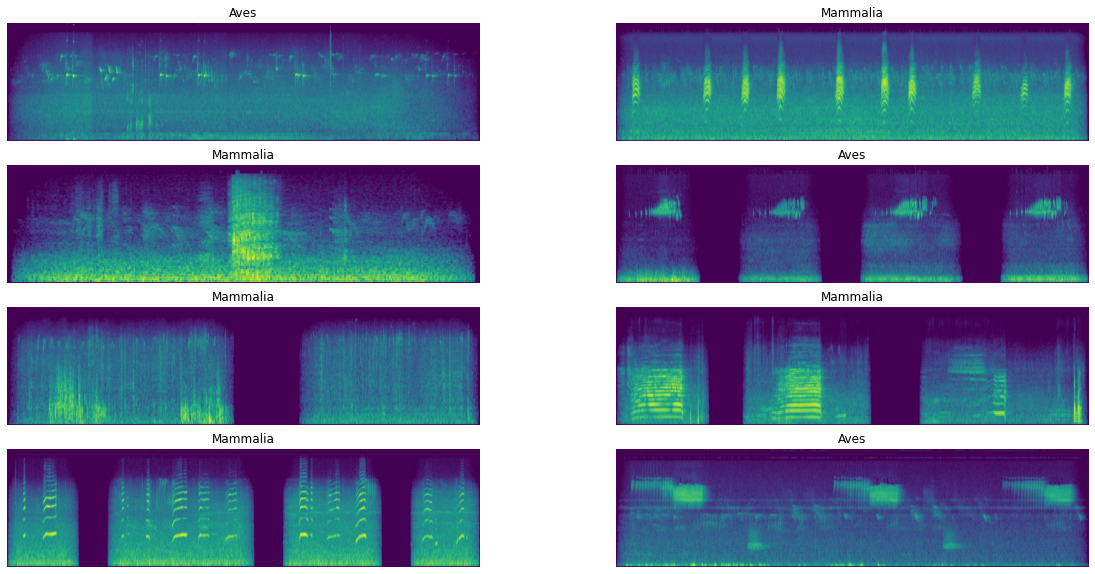

In [4]:
reload(utils)

transform_img = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

transform_labels = transforms.Compose(
    [transforms.ToTensor()]
)

dataset = utils.SpectrogramDataset("../datasets/Aves-Mammalia.csv", 
                                   "../spectrograms/small_dataset", 
                                   "gbifID", "class", 
                                   transform=transform_img, 
                                   one_hot_encode_labels=True)
dataset.show_sample(8, figsize=(20, 10))

In [5]:
test_percentage = .2
test_len = int((len(dataset) * test_percentage))
train_len = len(dataset) - test_len

train, test = random_split(dataset, [train_len, test_len], torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(train, batch_size=16)
test_loader = DataLoader(test, batch_size=16)

In [6]:
len(train_loader.dataset), len(test_loader.dataset)

(1600, 400)

In [7]:
net_archi["SimpleCNN2out"]

{'conv_channels': [8, 16, 32, 16, 8, 4],
 'conv_kernel_size': [2, 2, 2, 2, 2, 2],
 'pooling_size': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]],
 'linear_features': [64],
 'last_layer_activation': 'Softmax(dim=0)'}

In [8]:
reload(Simple_CNN)
net = Simple_CNN.SimpleCNN(3, [1024, 256], 2, net_archi["SimpleCNN2out"])

net = utils.cuda_network(net)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.001)

# torchsummary.summary(net, (3, 1024, 256))

CUDA available: converting network to CUDA


In [9]:
torchsummary.summary(net, (3, 1024, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 8, 1024, 256]             104
         MaxPool2d-2          [-1, 8, 512, 128]               0
              ReLU-3          [-1, 8, 512, 128]               0
            Conv2d-4         [-1, 16, 512, 128]             528
         MaxPool2d-5          [-1, 16, 256, 64]               0
              ReLU-6          [-1, 16, 256, 64]               0
            Conv2d-7          [-1, 32, 256, 64]           2,080
         MaxPool2d-8          [-1, 32, 128, 32]               0
              ReLU-9          [-1, 32, 128, 32]               0
           Conv2d-10          [-1, 16, 128, 32]           2,064
        MaxPool2d-11           [-1, 16, 64, 16]               0
             ReLU-12           [-1, 16, 64, 16]               0
           Conv2d-13            [-1, 8, 64, 16]             520
        MaxPool2d-14             [-1, 8

/home/pheithar/.local/lib/python3.9/site-packages/torch/nn/modules/conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /pytorch/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,
/home/pheithar/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
torch.cuda.empty_cache()
((train_loss, train_acc),
 (val_loss, val_acc)) = net.fit(100, train_loader, test_loader, criterion, optimizer,
                             log_file="train1.txt", plot_file="train1.png")

 98%|█████████████████████████████████████████▏| 98/100 [19:56<00:24, 12.19s/it]

In [ ]:
train_loss, train_acc, val_loss, val_acc